#### bclc

# Churn Prediction Model

In [17]:
#Base
import numpy as np
import pandas as pd
from datetime import datetime

#Visualization
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

#Data Optimization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
import timeit

#Analysis
import math
import statsmodels.api as sm
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_absolute_error

# 1. Eploratory Data Analysis

In [9]:
df = pd.read_csv('telecom.csv')

In [10]:
df['CustomerID'] = pd.DataFrame({'CustomerID': df.index})

In [11]:
df.head(3)

Churn  AccountWeeks  ContractRenewal  DataPlan  DataUsage  CustServCalls  \
0      0           128                1         1        2.7              1   
1      0           107                1         1        3.7              1   
2      0           137                1         0        0.0              0   

   DayMins  DayCalls  MonthlyCharge  OverageFee  RoamMins  CustomerID  
0    265.1       110           89.0        9.87      10.0           0  
1    161.6       123           82.0        9.78      13.7           1  
2    243.4       114           52.0        6.06      12.2           2

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Churn            3333 non-null   int64  
 1   AccountWeeks     3333 non-null   int64  
 2   ContractRenewal  3333 non-null   int64  
 3   DataPlan         3333 non-null   int64  
 4   DataUsage        3333 non-null   float64
 5   CustServCalls    3333 non-null   int64  
 6   DayMins          3333 non-null   float64
 7   DayCalls         3333 non-null   int64  
 8   MonthlyCharge    3333 non-null   float64
 9   OverageFee       3333 non-null   float64
 10  RoamMins         3333 non-null   float64
 11  CustomerID       3333 non-null   int64  
dtypes: float64(5), int64(7)
memory usage: 312.6 KB


In [13]:
df.isna().sum()

Churn              0
AccountWeeks       0
ContractRenewal    0
DataPlan           0
DataUsage          0
CustServCalls      0
DayMins            0
DayCalls           0
MonthlyCharge      0
OverageFee         0
RoamMins           0
CustomerID         0
dtype: int64

In [14]:
df = df.applymap(lambda x: x if x >= 0 else 0)

In [15]:
len(df)

3333

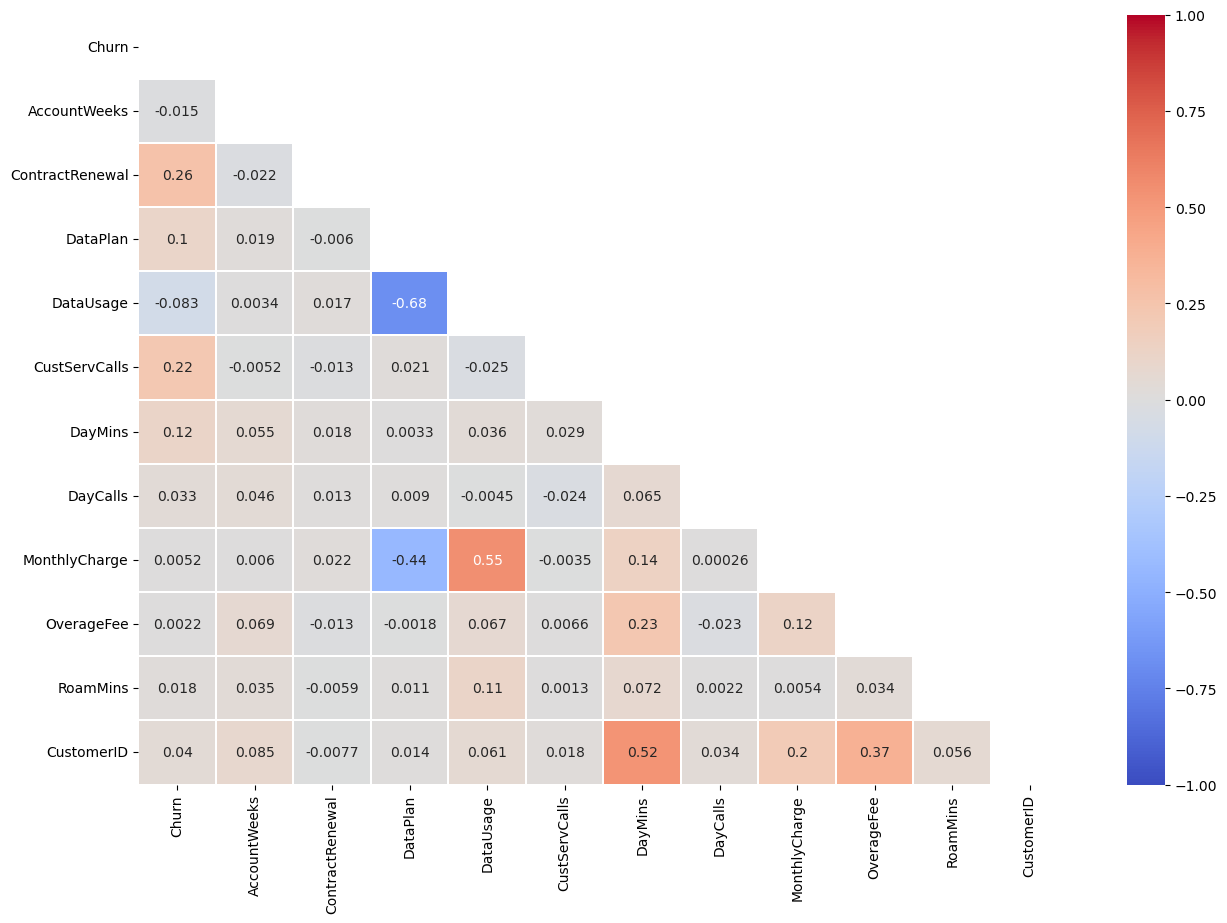

In [18]:
plt.figure(figsize=(15, 10))

corr = df.apply(lambda x: pd.factorize(x)[0]).corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

ax = sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2, cmap='coolwarm', vmin=-1, vmax=1)

In [19]:
#sns.pairplot(df, hue='churn_label')

In [20]:
c_labels = ['Not Churn','Churn']

# Define the colors
colors = ['#4C78A8','#F58518']

# Create a pie chart
fig = go.Figure()

# Add a trace to the pie chart with specified colors
fig.add_trace(go.Pie(
    labels=c_labels, 
    values=df['Churn'].value_counts(), 
    name="Churn",
    marker=dict(colors=colors)  # Set the colors
))

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name", textfont_size=16)

# Show the plot
fig.show()

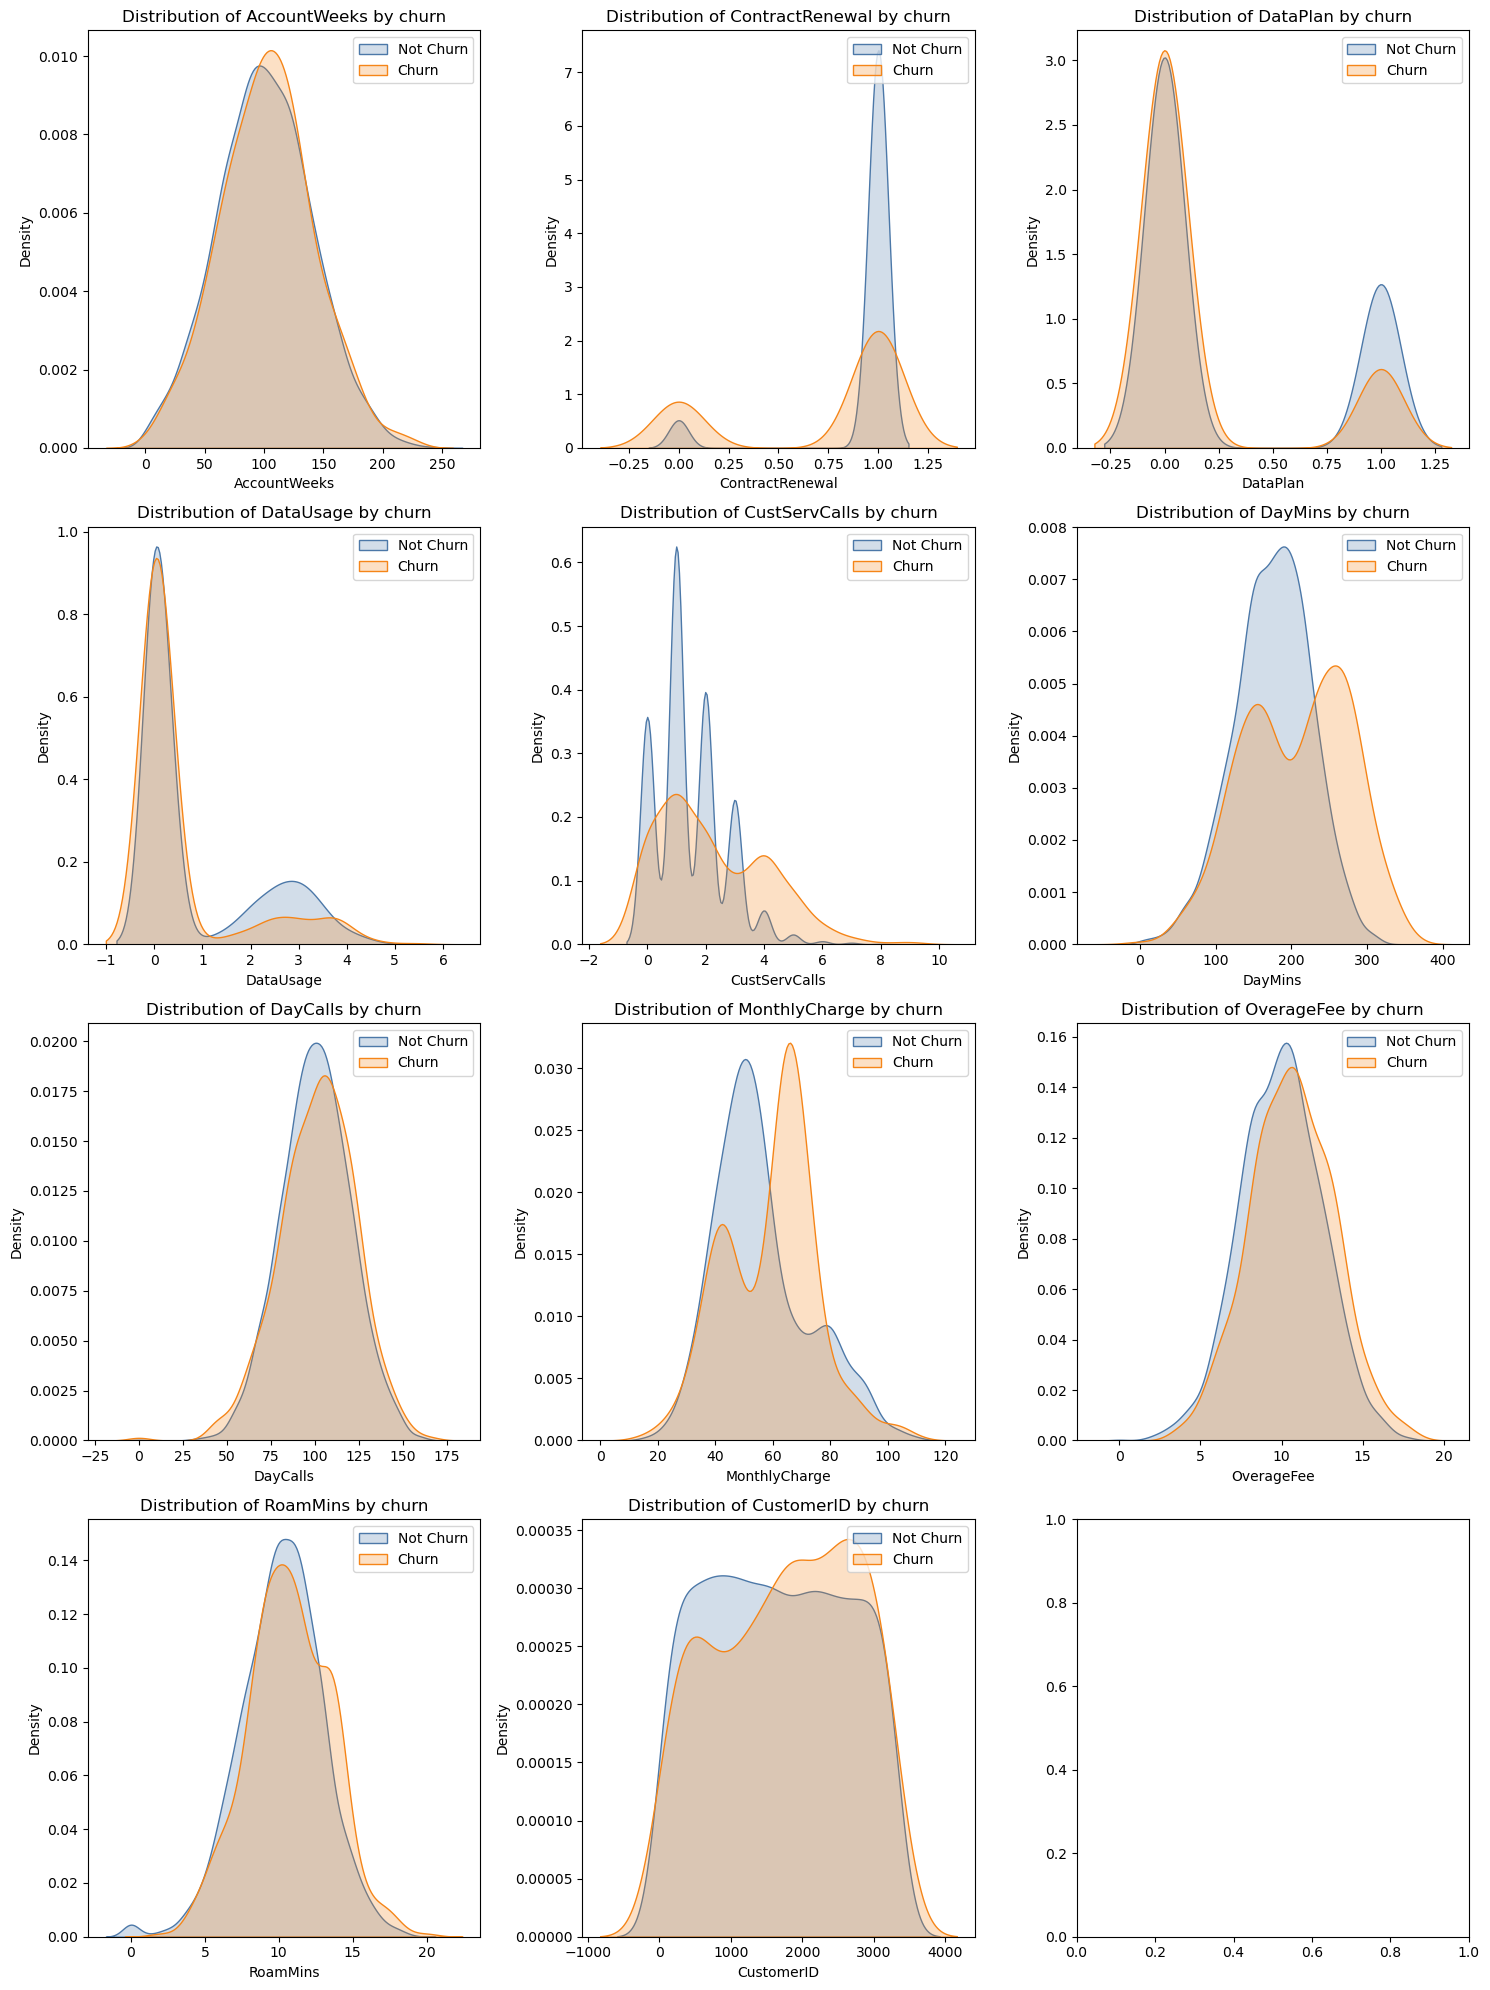

In [22]:
# Identify numeric columns (excluding 'churn_label')
numeric_columns = df.select_dtypes(include='number').columns.drop('Churn')

# Calculate number of rows needed
num_plots = len(numeric_columns)
num_cols = 3
num_rows = math.ceil(num_plots / num_cols)

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5*num_rows))

# Iterate through numeric columns and create KDE plots
for i, column in enumerate(numeric_columns):
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = sns.kdeplot(df[column][(df["Churn"] == 0)], color="#4C78A8", fill=True, ax=axes[row_idx, col_idx])
    ax = sns.kdeplot(df[column][(df["Churn"] == 1)], ax=ax, color="#F58518", fill=True)
    ax.legend(["Not Churn", "Churn"], loc='upper right')
    ax.set_ylabel('Density')
    ax.set_xlabel(column)
    ax.set_title(f'Distribution of {column} by churn')

# Adjust layout
plt.tight_layout()
plt.show()

In [23]:
df_transformed = df.copy()
df_transformed  = df_transformed.drop(columns='Churn')
df_transformed = np.log(df_transformed+1)


In [24]:
df_transformed.isna().sum()

AccountWeeks       0
ContractRenewal    0
DataPlan           0
DataUsage          0
CustServCalls      0
DayMins            0
DayCalls           0
MonthlyCharge      0
OverageFee         0
RoamMins           0
CustomerID         0
dtype: int64

In [25]:
inf_values = np.isinf(df_transformed).sum()
inf_values

AccountWeeks       0
ContractRenewal    0
DataPlan           0
DataUsage          0
CustServCalls      0
DayMins            0
DayCalls           0
MonthlyCharge      0
OverageFee         0
RoamMins           0
CustomerID         0
dtype: int64

In [26]:
df_transformed=df_transformed.fillna(0)

In [27]:
df_transformed['Churn'] = df['Churn']

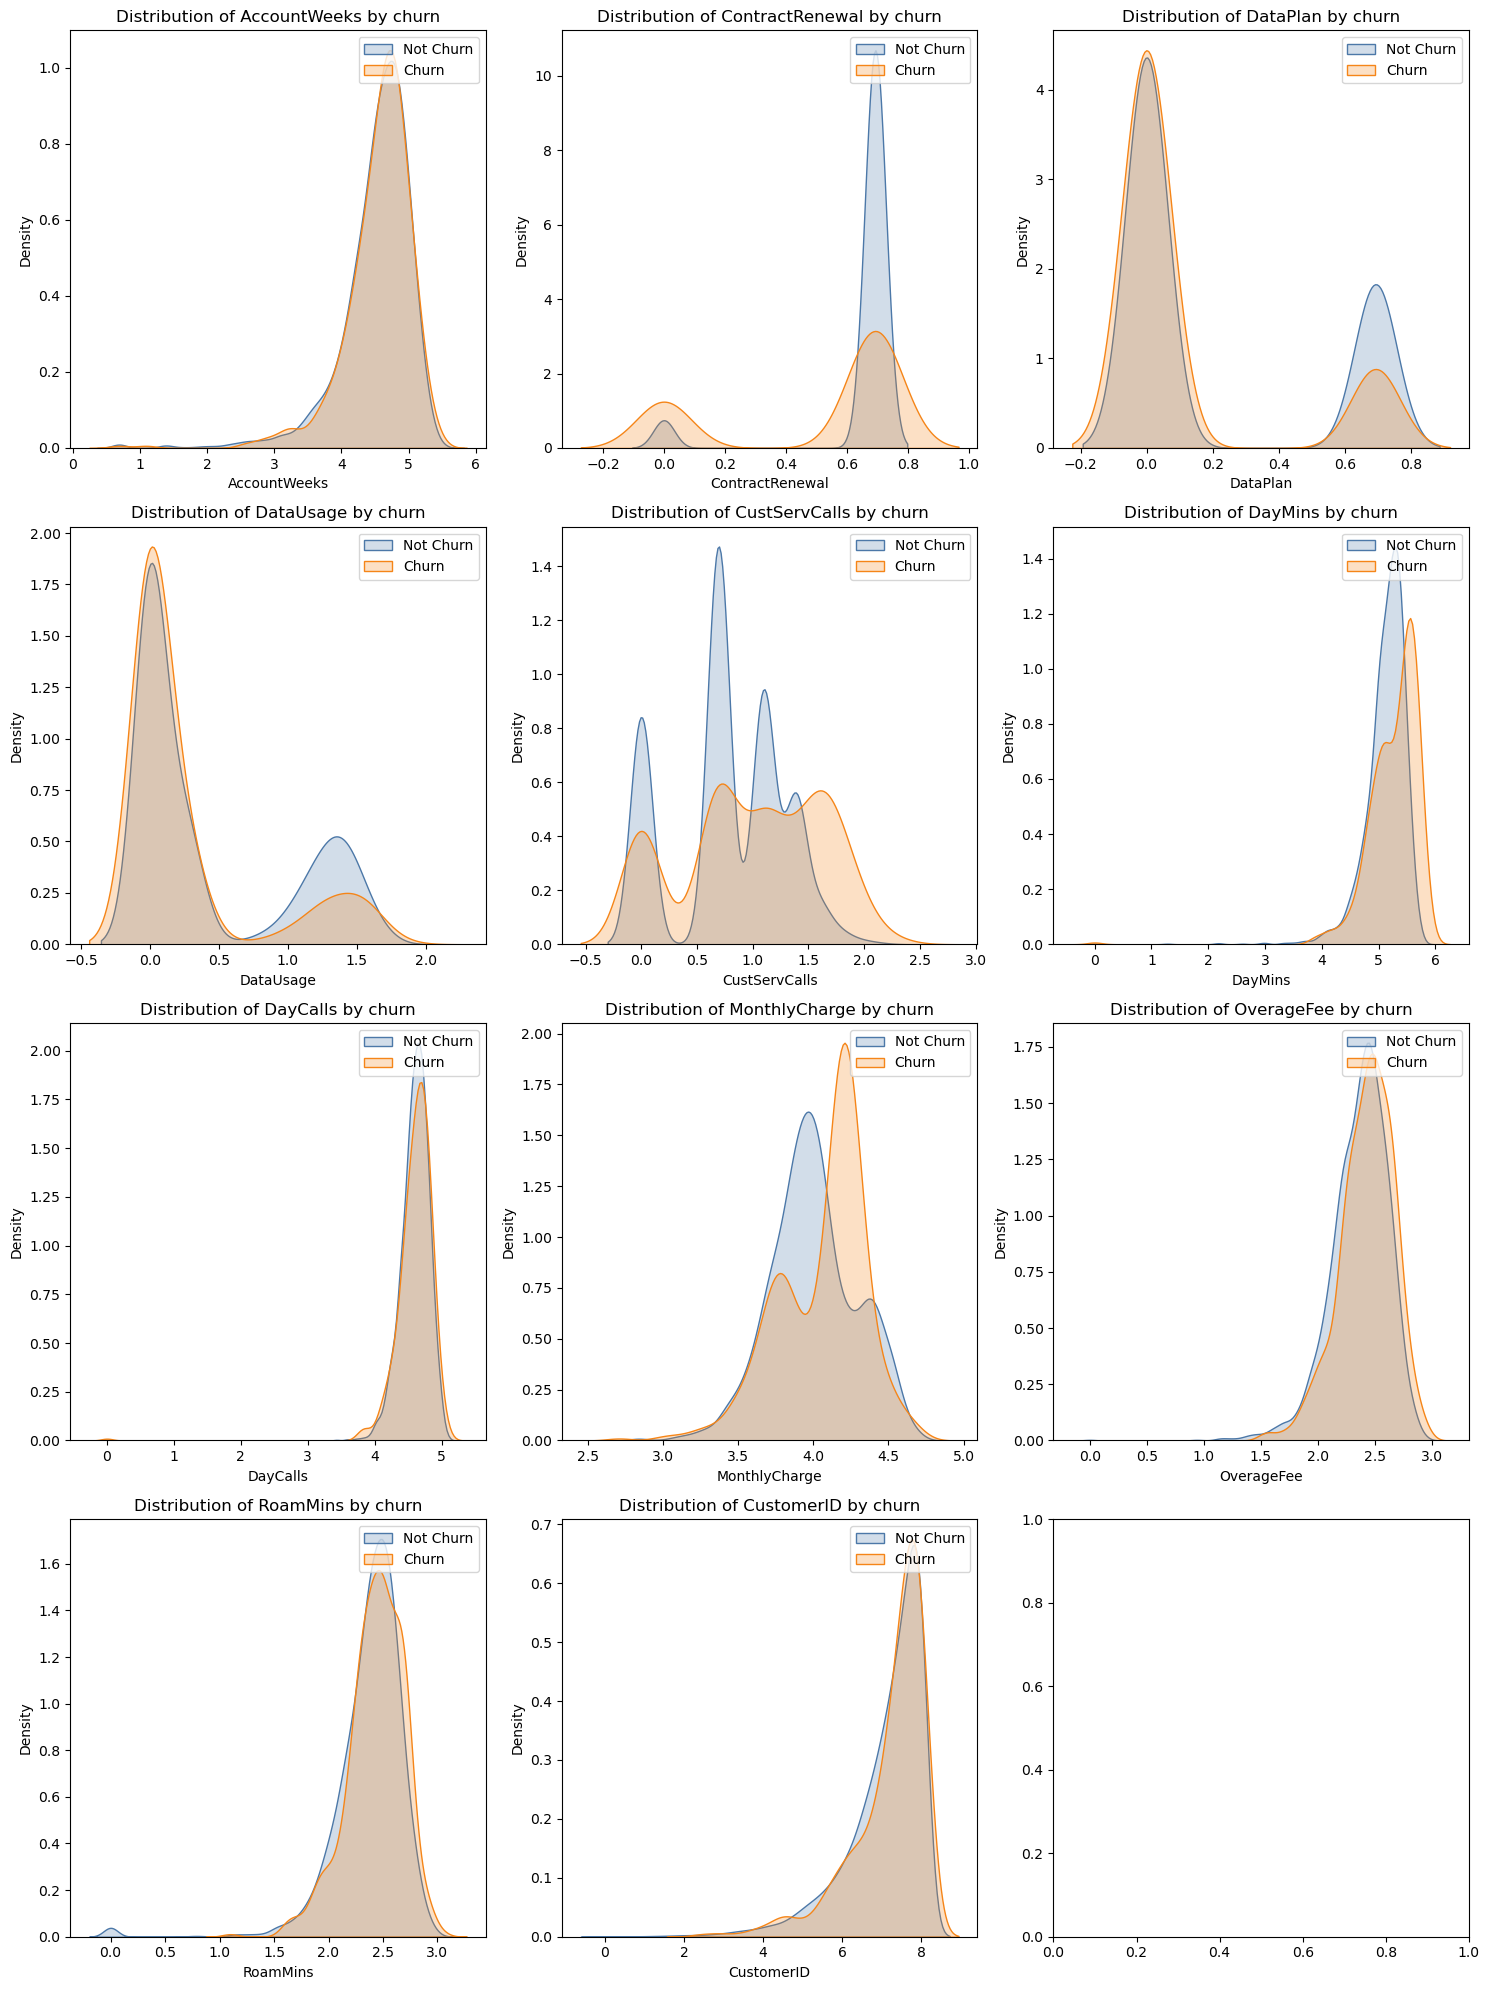

In [29]:
# Identify numeric columns (excluding 'churn_label')
numeric_columns = df_transformed.select_dtypes(include='number').columns.drop('Churn')

# Calculate number of rows needed
num_plots = len(numeric_columns)
num_cols = 3
num_rows = math.ceil(num_plots / num_cols)

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5*num_rows))

# Iterate through numeric columns and create KDE plots
for i, column in enumerate(numeric_columns):
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = sns.kdeplot(df_transformed[column][(df_transformed["Churn"] == 0)], color="#4C78A8", fill=True, ax=axes[row_idx, col_idx])
    ax = sns.kdeplot(df_transformed[column][(df_transformed["Churn"] == 1)], ax=ax, color="#F58518", fill=True)
    ax.legend(["Not Churn", "Churn"], loc='upper right')
    ax.set_ylabel('Density')
    ax.set_xlabel(column)
    ax.set_title(f'Distribution of {column} by churn')

# Adjust layout
plt.tight_layout()
plt.show()

In [30]:
X = df.drop('Churn', axis=1)
y = df['Churn']

In [31]:
X_const = sm.add_constant(X)
linearregression = sm.OLS(y, X_const)
results = linearregression.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Churn   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     64.62
Date:                Sun, 25 Feb 2024   Prob (F-statistic):          3.27e-131
Time:                        20:49:26   Log-Likelihood:                -926.16
No. Observations:                3333   AIC:                             1876.
Df Residuals:                    3321   BIC:                             1950.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.1649      0.054     -3.040      0.002      -0.271      -0.059
AccountWeeks     7.517e-05      0.000      0.538      0.590      -0.000       0.000
ContractRenewal    -0.2997      0.019    -15.934      0.000      -0.337      -0.263
DataPlan           -0.0448      0.044     -1.024      0.306      -0.131       0.041
DataUsage          -0.0230      0.193     -0.119      0.905      -0.402       0.356
CustServCalls       0.0582      0.004     13.792      0.000       0.050       0.066
DayMins             0.0011      0.003      0.335      0.738      -0.005       0.008
DayCalls            0.0003      0.000      1.234      0.217      -0.000       0.001
MonthlyCharge       0.0010      0.019      0.053      0.957      -0.037       0.039
OverageFee          0.0111      0.033      0.338      0.736      -0.053       0.075
RoamMins            0.0086      0.002      3.747      0.000       0.004       0.013
CustomerID       1.477e-05   5.77e-06      2.558      0.011    3.45e-06    2.61e-05
==============================================================================
Omnibus:                      830.352   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1643.072
Skew:                           1.512   Prob(JB):                         0.00
Kurtosis:                       4.640   Cond. No.                     6.88e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.88e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [32]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [33]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
my_PCA = PCA(n_components=0.8)
my_PCA.fit(X_scaled)
X_pca = my_PCA.transform(X_scaled)
num_dimensions = X_pca[1]
len(num_dimensions)

7

In [36]:
X = df_transformed.drop('Churn', axis=1)
y = df_transformed['Churn']

In [37]:
X_const = sm.add_constant(X)
linearregression = sm.OLS(y, X_const)
results = linearregression.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Churn   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     54.17
Date:                Sun, 25 Feb 2024   Prob (F-statistic):          1.24e-110
Time:                        20:50:25   Log-Likelihood:                -974.38
No. Observations:                3333   AIC:                             1973.
Df Residuals:                    3321   BIC:                             2046.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.5355      0.179     -8.575      0.000      -1.887      -1.184
AccountWeeks        0.0077      0.011      0.727      0.467      -0.013       0.028
ContractRenewal    -0.4358      0.028    -15.840      0.000      -0.490      -0.382
DataPlan            0.0283      0.075      0.379      0.705      -0.118       0.175
DataUsage          -0.3620      0.050     -7.189      0.000      -0.461      -0.263
CustServCalls       0.1066      0.011      9.836      0.000       0.085       0.128
DayMins            -0.2433      0.041     -5.941      0.000      -0.324      -0.163
DayCalls            0.0262      0.025      1.069      0.285      -0.022       0.074
MonthlyCharge       0.7967      0.084      9.456      0.000       0.631       0.962
OverageFee         -0.1402      0.035     -3.980      0.000      -0.209      -0.071
RoamMins            0.0646      0.019      3.325      0.001       0.026       0.103
CustomerID          0.0126      0.006      2.231      0.026       0.002       0.024
==============================================================================
Omnibus:                      897.539   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1871.813
Skew:                           1.601   Prob(JB):                         0.00
Kurtosis:                       4.797   Cond. No.                         406.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [39]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
my_PCA = PCA(n_components=0.8)
my_PCA.fit(X_scaled)
X_pca = my_PCA.transform(X_scaled)
num_dimensions = X_pca[1]
len(num_dimensions)

7

# 2.Machine Learning Model Evaluations and Predictions

# 2.1 Train, Validation, Test split

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [40]:
# X = df_transformed.drop('churn_label', axis=1)
# y = df_transformed['churn_label']

X = df.drop('Churn', axis=1)
y = df['Churn']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [41]:
X_test

array([[ 0.31707098,  0.32428911, -0.61219198, ...,  2.55303024,
         1.16723428, -1.31285701],
       [-0.83851632,  0.32428911, -0.61219198, ...,  0.32296391,
         0.91638743,  1.04241017],
       [-0.05975096,  0.32428911, -0.61219198, ..., -0.81570954,
        -1.23372843, -0.35747806],
       ...,
       [ 0.09097782,  0.32428911, -0.61219198, ..., -0.83540977,
         0.09217635,  1.29731833],
       [-0.91388071,  0.32428911, -0.61219198, ..., -0.66992782,
        -0.08699997,  1.02239671],
       [ 0.69389293,  0.32428911, -0.61219198, ...,  0.88639056,
        -1.37706949, -0.55339921]])

In [42]:
len(X_train)

2333

In [43]:
len(X_test)

1000

# 2.2 Train and Evaluate function

In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score


In [45]:
# Function to train and evaluate a model and return ROC-AUC score
def train_evaluate_model(clf, param_grid, X_train, y_train, X_test, y_test):
    grid_search = GridSearchCV(clf, param_grid=param_grid, scoring='roc_auc', cv=5)
    fitted_search = grid_search.fit(X_train, y_train)
    best_params = fitted_search.best_params_
    
    clf = clf.set_params(**best_params)
    clf.fit(X_train, y_train)

    y_probabilities = clf.predict_proba(X_test)[:, 1]
    
    roc_auc = roc_auc_score(y_test, y_probabilities)
    
    return clf, roc_auc, y_probabilities, best_params

# DataFrames for storing results
results_dfs = []

# 2.3 Models

# 2.3.1 Random Forest

In [46]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
# RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42)
rf_param_grid = {'n_estimators': [5, 10, 25, 50]}
rf_model, rf_roc_auc, rf_probabilities, rf_best_params = train_evaluate_model(rf_clf, rf_param_grid, X_train, y_train, X_test, y_test)
results_df_rf = pd.DataFrame({'CustomerID': y_test.index, 'Churn_Probability': rf_probabilities})
results_df_rf.set_index('CustomerID', inplace=True)
results_dfs.append(('RandomForest', rf_roc_auc, results_df_rf))

# 2.3.2 XGBoost

In [48]:
from xgboost import XGBClassifier

In [49]:
# XGBClassifier
xgb_clf = XGBClassifier(random_state=42)
xgb_param_grid = {'n_estimators': [5, 10, 25, 50]}
xgb_model, xgb_roc_auc, xgb_probabilities, xgb_best_params = train_evaluate_model(xgb_clf, xgb_param_grid, X_train, y_train, X_test, y_test)
results_df_xgb = pd.DataFrame({'CustomerID': y_test.index, 'Churn_Probability': xgb_probabilities})
results_df_xgb.set_index('CustomerID', inplace=True)
results_dfs.append(('XGBClassifier', xgb_roc_auc, results_df_xgb))

# 2.3.3 GradientBoosting

In [50]:
 from sklearn.ensemble import GradientBoostingClassifier

In [51]:
# GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(random_state=42)
gb_param_grid = {'loss': ['log_loss', 'exponential'], 'learning_rate': [0.001, 0.1, 1, 10], 'n_estimators': [5, 10, 25, 50]}
gb_model, gb_roc_auc, gb_probabilities, gb_best_params = train_evaluate_model(gb_clf, gb_param_grid, X_train, y_train, X_test, y_test)
results_df_gb = pd.DataFrame({'CustomerID': y_test.index, 'Churn_Probability': gb_probabilities})
results_df_gb.set_index('CustomerID', inplace=True)
results_dfs.append(('GradientBoosting', gb_roc_auc, results_df_gb))

# 2.3.4 KNearestNeighbors

In [52]:
from sklearn.neighbors import KNeighborsClassifier

In [53]:
# K-Nearest Neighbors (KNN)
knn_clf = KNeighborsClassifier()
knn_param_grid = {'n_neighbors': list(range(1, 20))}
knn_model, knn_roc_auc, knn_probabilities, knn_best_params = train_evaluate_model(knn_clf, knn_param_grid, X_train, y_train, X_test, y_test)
results_df_knn = pd.DataFrame({'CustomerID': y_test.index, 'Churn_Probability': knn_probabilities})
results_df_knn.set_index('CustomerID', inplace=True)
results_dfs.append(('KNN', knn_roc_auc, results_df_knn))

# 2.3.5 Support Vector Machines

In [54]:
# from sklearn.svm import SVC

In [55]:
# # Support Vector Machines (SVM)
# svm_clf = SVC(probability=True)
# svm_param_grid = {'C': [1], 'kernel': ['linear', 'rbf']}
# svm_model, svm_roc_auc, svm_probabilities, svm_best_params = train_evaluate_model(svm_clf, svm_param_grid, X_train, y_train, X_test, y_test)
# results_df_svm = pd.DataFrame({'CustomerID': y_test.index, 'Churn_Probability': svm_probabilities})
# results_df_svm.set_index('CustomerID', inplace=True)
# results_dfs.append(('SVM', svm_roc_auc, results_df_svm))

# 2.3.6 Naive Bayes (Gaussian)

In [56]:
from sklearn.naive_bayes import GaussianNB

In [57]:
# Gaussian Naive Bayes
nb_clf = GaussianNB()
nb_model, nb_roc_auc, nb_probabilities, nb_best_params = train_evaluate_model(nb_clf, {}, X_train, y_train, X_test, y_test)
results_df_nb = pd.DataFrame({'CustomerID': y_test.index, 'Churn_Probability': nb_probabilities})
results_df_nb.set_index('CustomerID', inplace=True)
results_dfs.append(('NaiveBayes', nb_roc_auc, results_df_nb))

# 2.3.7 Neural Network - sklearn

In [58]:
from sklearn.neural_network import MLPClassifier

In [59]:
# Neural Network (MLPClassifier)
nn_clf = MLPClassifier(max_iter=1000, random_state=42)  # You can adjust max_iter and other parameters
nn_param_grid = {'hidden_layer_sizes': [(50,), (100,), (50, 50)]}
nn_model, nn_roc_auc, nn_probabilities, nn_best_params = train_evaluate_model(nn_clf, nn_param_grid, X_train, y_train, X_test, y_test)
results_df_nn = pd.DataFrame({'CustomerID': y_test.index, 'Churn_Probability': nn_probabilities})
results_df_nn.set_index('CustomerID', inplace=True)
results_dfs.append(('NeuralNetwork', nn_roc_auc, results_df_nn))

C:\Users\jverdugo\AppData\Local\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.

C:\Users\jverdugo\AppData\Local\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.

C:\Users\jverdugo\AppData\Local\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.

C:\Users\jverdugo\AppData\Local\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.

C:\Users\jverdugo\AppData\Local\anaconda3\Lib\site-packages\

In [60]:
nn_clf = MLPClassifier(**nn_best_params,max_iter=1000, random_state=42)
y_pred_nn = nn_clf.fit(X_train, y_train)
# Make predictions on the test set
y_pred_nn = nn_clf.predict(X_test)
y_pred_nn  

C:\Users\jverdugo\AppData\Local\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.



array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,

# 2.3.8 Neural Network - TensorFlow

In [61]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [62]:
# TensorFlow/Keras
def build_neural_network(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Neural Network with TensorFlow/Keras
nn_tf_model = build_neural_network(X_train.shape[1])
nn_tf_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Make predictions on the test set
nn_tf_probabilities = nn_tf_model.predict(X_test)
nn_tf_roc_auc = roc_auc_score(y_test, nn_tf_probabilities)

# Create a DataFrame with customer IDs and their corresponding probabilities
results_df_nn_tf = pd.DataFrame({'CustomerID':  y_test.index, 'Churn_Probability': nn_tf_probabilities.flatten()})
results_df_nn_tf.set_index('CustomerID', inplace=True)
results_dfs.append(('NeuralNetwork_TF', nn_tf_roc_auc, results_df_nn_tf))





32/32 [==============================] - 0s 977us/step


# 2.3.9 Neural Network - PyTorch

In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [64]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)


# Define the neural network class
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# Instantiate the neural network
input_size = X_train_tensor.shape[1]
nn_pytorch_model = NeuralNetwork(input_size)

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(nn_pytorch_model.parameters(), lr=0.001)

# Train the neural network
for epoch in range(10):  # You can adjust the number of epochs
    outputs = nn_pytorch_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor.view(-1, 1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Make predictions on the test set
nn_pytorch_model.eval()
with torch.no_grad():
    nn_pytorch_probabilities = nn_pytorch_model(X_test_tensor).numpy()

# Create a DataFrame with customer IDs and their corresponding probabilities
results_df_nn_pytorch = pd.DataFrame({'CustomerID': y_test.index, 'Churn_Probability': nn_pytorch_probabilities.flatten()})
results_df_nn_pytorch.set_index('CustomerID', inplace=True)
results_dfs.append(('NeuralNetwork_PyTorch', 0.0, results_df_nn_pytorch))  # ROC-AUC not computed for simplicity

# 2.4 Find Best Model

In [65]:
from sklearn.metrics import classification_report

def train_evaluate_model_class_report(model, X_train, y_train, X_test, y_test, model_name):
    
    # Make predictions on the test set
    if model_name == "NeuralNetwork_PyTorch":
        # For PyTorch neural network model
        threshold=0.5
        y_prob = nn_pytorch_model(X_test_tensor).detach().numpy()
        y_pred = (y_prob > threshold).astype(int)  # Convert probabilities to class labels
        # Display classification report
        report = classification_report(y_test, y_pred)
        
    elif model_name == "NeuralNetwork_TF":
        # For TensorFlow neural network model
        model.fit(X_train, y_train)
        threshold=0.5
        y_prob = model.predict(X_test)  # Assuming model is a TensorFlow model with predict method
        y_pred = (y_prob > threshold).astype(int)  # Convert probabilities to class labels
        # Display classification report with plot
        report = classification_report(y_test, y_pred)
        lines = report.split('\n')
        report = '\n'.join(line for line in lines if '=====' not in line)
    else:
        # For other models
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        # Display classification report
        report = classification_report(y_test, y_pred)
    
    print(f"Classification Report - {model_name}:\n{report}")

    # Return the model for further analysis if needed
    return model

In [66]:
# Train, evaluate, and display classification report for each model
models = [
    ('RandomForest', RandomForestClassifier(**rf_best_params, random_state=42)),
    ('XGBoost', XGBClassifier(**xgb_best_params, random_state=42)),
    ('GradientBoosting', GradientBoostingClassifier(**gb_best_params)),
    ('KNN', KNeighborsClassifier(**knn_best_params)),
#    ('SVM', SVC(probability=True)),
    ('NaiveBayes', GaussianNB(**nb_best_params)),
    ('NeuralNetwork', MLPClassifier(**nn_best_params,max_iter=1000, random_state=42)),
    ('NeuralNetwork_TF', build_neural_network(X_train.shape[1])),
    ('NeuralNetwork_PyTorch', NeuralNetwork(input_size)),
]

for model_name, model in models:
    train_evaluate_model_class_report(model, X_train, y_train, X_test, y_test, model_name)

Classification Report - RandomForest:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       857
           1       0.86      0.63      0.73       143

    accuracy                           0.93      1000
   macro avg       0.90      0.81      0.84      1000
weighted avg       0.93      0.93      0.93      1000

Classification Report - XGBoost:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       857
           1       0.89      0.60      0.72       143

    accuracy                           0.93      1000
   macro avg       0.91      0.79      0.84      1000
weighted avg       0.93      0.93      0.93      1000

Classification Report - GradientBoosting:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       857
           1       0.90      0.61      0.73       143

    accuracy                           0.93      1000
   macro avg   

C:\Users\jverdugo\AppData\Local\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.



Classification Report - NeuralNetwork:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       857
           1       0.77      0.62      0.68       143

    accuracy                           0.92      1000
   macro avg       0.85      0.79      0.82      1000
weighted avg       0.91      0.92      0.91      1000

32/32 [==============================] - 0s 820us/step
Classification Report - NeuralNetwork_TF:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       857
           1       0.00      0.00      0.00       143

    accuracy                           0.86      1000
   macro avg       0.43      0.50      0.46      1000
weighted avg       0.73      0.86      0.79      1000

Classification Report - NeuralNetwork_PyTorch:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       857
           1       0.00      0.00      0.00       143


C:\Users\jverdugo\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\jverdugo\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\jverdugo\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [67]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [68]:
# Initialize the figure
fig = go.Figure()

# RandomForestClassifier
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probabilities)
roc_auc_rf = auc(fpr_rf, tpr_rf)
fig.add_trace(go.Scatter(x=fpr_rf, y=tpr_rf, mode='lines', name=f'RandomForest (AUC = {roc_auc_rf:.2f})'))

# XGBClassifier
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probabilities)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
fig.add_trace(go.Scatter(x=fpr_xgb, y=tpr_xgb, mode='lines', name=f'XGBClassifier (AUC = {roc_auc_xgb:.2f})'))

# GradientBoostingClassifier
fpr_gb, tpr_gb, _ = roc_curve(y_test, gb_probabilities)
roc_auc_gb = auc(fpr_gb, tpr_gb)
fig.add_trace(go.Scatter(x=fpr_gb, y=tpr_gb, mode='lines', name=f'GradientBoosting (AUC = {roc_auc_gb:.2f})'))

# K-Nearest Neighbors (KNN)
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_probabilities)
roc_auc_knn = auc(fpr_knn, tpr_knn)
fig.add_trace(go.Scatter(x=fpr_knn, y=tpr_knn, mode='lines', name=f'KNN (AUC = {roc_auc_knn:.2f})'))

# Naive Bayes (Gaussian)
fpr_nb, tpr_nb, _ = roc_curve(y_test, nb_probabilities)
roc_auc_nb = auc(fpr_nb, tpr_nb)
fig.add_trace(go.Scatter(x=fpr_nb, y=tpr_nb, mode='lines', name=f'NaiveBayes (AUC = {roc_auc_nb:.2f})'))

# Neural Network (MLPClassifier)
fpr_nn, tpr_nn, _ = roc_curve(y_test, nn_probabilities)
roc_auc_nn = auc(fpr_nn, tpr_nn)
fig.add_trace(go.Scatter(x=fpr_nn, y=tpr_nn, mode='lines', name=f'NeuralNetwork (AUC = {roc_auc_nn:.2f})'))

# Neural Network with TensorFlow/Keras
fpr_nn_tf, tpr_nn_tf, _ = roc_curve(y_test, nn_tf_probabilities)
roc_auc_nn_tf = auc(fpr_nn_tf, tpr_nn_tf)
fig.add_trace(go.Scatter(x=fpr_nn_tf, y=tpr_nn_tf, mode='lines', name=f'NeuralNetwork_TF (AUC = {roc_auc_nn_tf:.2f})'))

# Neural Network with PyTorch
fpr_nn_pytorch, tpr_nn_pytorch, _ = roc_curve(y_test, nn_pytorch_probabilities)
roc_auc_nn_pytorch = auc(fpr_nn_pytorch, tpr_nn_pytorch)
fig.add_trace(go.Scatter(x=fpr_nn_pytorch, y=tpr_nn_pytorch, mode='lines', name=f'NeuralNetwork_PyTorch (AUC = {roc_auc_nn_pytorch:.2f})'))

# Add the diagonal line
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(dash='dash'), name='Diagonal'))

# Update layout
fig.update_layout(
    xaxis=dict(title='False Positive Rate'),
    yaxis=dict(title='True Positive Rate'),
    title='Receiver Operating Characteristic (ROC) Curve',
    legend=dict(x=0, y=1.1),
    margin=dict(l=20, r=20, t=40, b=20)
)

# Show the figure
fig.show()

In [69]:
# Find the model with the highest ROC-AUC score
best_model, _, best_results_df = max(results_dfs, key=lambda x: x[1])

In [70]:
best_results_df

Churn_Probability
CustomerID                   
438                      0.28
2674                     0.08
1345                     0.88
1957                     0.04
2148                     0.04
...                       ...
3080                     0.04
2548                     0.08
2916                     0.04
2655                     0.04
1159                     0.04

[1000 rows x 1 columns]